# MENNPDF with 1D examples

This notebook illustrates the usage of the MENNPDF method over some examples.

## Configuration

In [1]:
import tensorflow as tf
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from mennpdf_monovariate import SimpleMaxEntrLayer, SimpleMaxEntrModel, trapezoidInt
from ressources.mmd_tools import mmd2u, mmd2uEigValSample, pValueCalc
from ressources.custom_distributions import SpikeGen, CamelGen

2025-03-20 15:41:07.287294: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 15:41:07.316660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 15:41:07.720165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2025-03-20 15:41:08.781032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:41:08.805526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-20 15:41:08.805680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Selection of multiple pre-configured distributions to replicate the paper's examples:

In [3]:
distrName = 'spike'

match distrName:
        case 'arcsine' :
            name = 'arcsine'
            distr = st.arcsine(scale=2.)
        case 'semicircular' :
            name = 'semicircular'
            distr = st.semicircular()
        case 'weibull' :
            name = 'truncated weibull min'
            distr = st.truncweibull_min(2., 0., 3.)
        case 'trapezoid' :
            name = 'trapezoid'
            distr = st.trapezoid(.2, .6, loc=0, scale=4.8)
        case 'camel' :
            name = 'camel'
            distr = CamelGen()
        case 'spike' :
            name = 'spike'
            distr = SpikeGen()
        case 'custom' :
            name = None
            distr = None                                    # Needs a distributions behaving like scipy.stats distributions with the methods rvs and pdf implemented

In [4]:
n = 1000                      # number of samples
sample = distr.rvs(size=n)

Illustration of the training sample

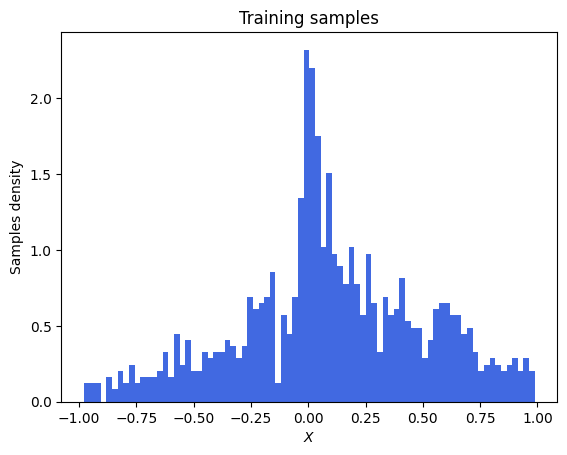

In [5]:
plt.figure()
plt.hist(sample, bins=80, density=True, color="royalblue")
plt.xlabel(r"$X$")
plt.ylabel("Samples density")
_ = plt.title("Training samples")

Points and weights used for the integration.

In [6]:
intPts, intWeights = trapezoidInt(10000, sample.min(), sample.max())

Definition of the neural network and the model.

In [7]:
gNN = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.GaussianNoise(.001),
    tf.keras.layers.Dense(16, activation='swish'), 
    tf.keras.layers.Dense(8, activation='swish'),
    tf.keras.layers.Dense(4, activation='swish'),
    tf.keras.layers.Dense(1, activation='linear')
])

MElay = SimpleMaxEntrLayer(intPts, intWeights)
MEmod = SimpleMaxEntrModel(gNN, MElay)

In [8]:
gNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209 (836.00 B)

 Trainable params: 209 (836.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
MEmod.compile(optimizer=tf.optimizers.Adam(3e-3))
countedEpochs = 0
hist = None

MEmod.run_eagerly = False
# MEmod.run_eagerly = True

**Training**

In [10]:
epochsToDo = 2000
histKeras = MEmod.fit(x=sample, y=None, batch_size=sample.shape[0], epochs=epochsToDo+countedEpochs , initial_epoch=countedEpochs, verbose=0)
countedEpochs += epochsToDo
if hist == None:
    hist = histKeras.history
else:
    {hist[k].extend(v) for k, v in histKeras.history.items()}

I0000 00:00:1742481670.317456 1737438 service.cc:145] XLA service 0x726810015e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742481670.317480 1737438 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-20 15:41:10.335150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-20 15:41:10.441576: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-03-20 15:41:11.234105: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

The loss has no direct interpretation.
We plot the evolution of the loss compared to the minimal value in log-scale to visualize its descent.

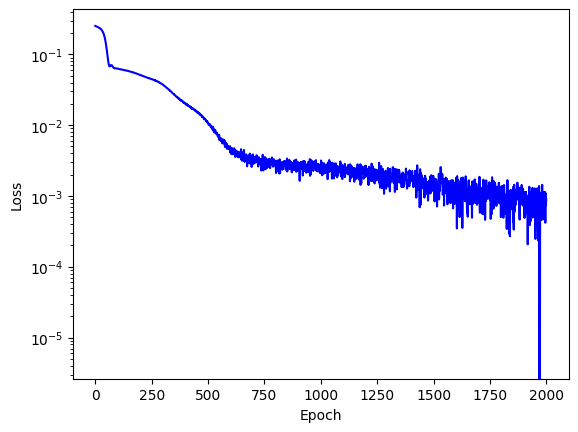

In [11]:
arrHist = np.array(hist['gamma'])
plt.figure()
plt.plot(arrHist - arrHist.min(), '-b')
plt.xlabel("Epoch")
plt.yscale("log")
_ = plt.ylabel("Loss")

## Results

Comparison between the PDF of the distribution used to generate the sample and the estimated PDF over that sample.

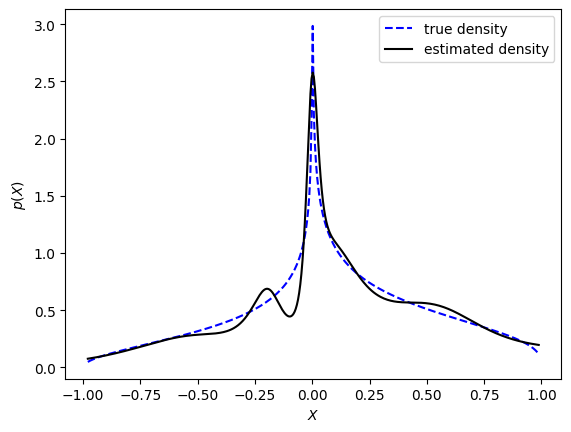

In [12]:
minSample, maxSample = sample.min(), sample.max()
x = np.linspace(minSample, maxSample, 400)

refVal = distr.pdf(x)
estVal = np.array(MEmod(x))

plt.figure()
plt.plot(x, refVal, '--b', label='true density')
plt.plot(x, estVal, 'k', label='estimated density')
plt.xlabel(r'$X$')
plt.ylabel(r'$p\left(X\right)$')
_ = plt.legend()

Generation of a sample with the estimated PDF

In [13]:
nbSamples = 10
estSamples = [MEmod.rvs(n).numpy() for _ in range(nbSamples)]

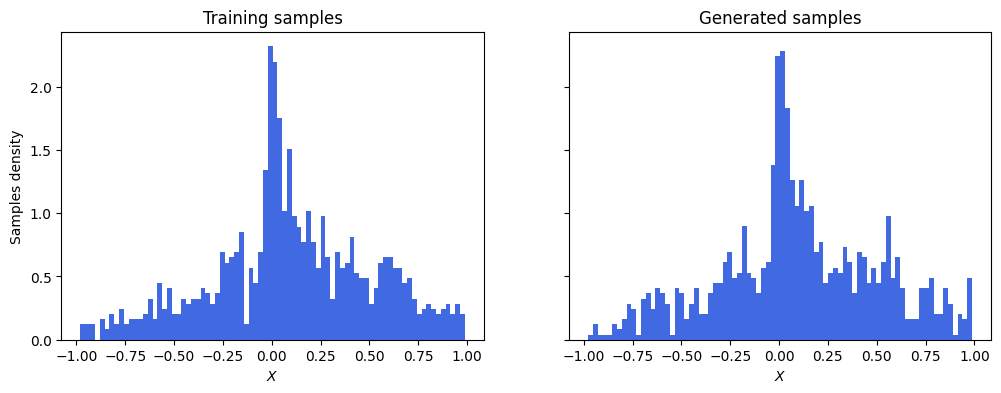

In [14]:
figHist, axHist = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
idSample = 0

axHist[0].hist(sample, bins=80, density=True, color="royalblue")
axHist[1].hist(estSamples[idSample], bins=80, density=True, color="royalblue")
axHist[0].set_xlabel(r"$X$")
axHist[1].set_xlabel(r"$X$")
axHist[0].set_ylabel("Samples density")
axHist[0].set_title("Training samples")
_ = axHist[1].set_title("Generated samples")

Assessing the result with the MMD<sub>u</sub><sup>2</sup> metric

In [15]:
def mmdAndPval(i):  
    MMD2u = mmd2u(sample[None, :], estSamples[i][None, :])
    pValue = pValueCalc(mmd2uEigValSample(sample[None, :], estSamples[i][None, :], nbSamp=10000), MMD2u)
    return MMD2u, pValue


In [16]:
MMDs, pVals = [], []
for i in range(nbSamples):
    print(f"Computing MMD and p-value on sample n°{i+1} out of {nbSamples}")
    MMD2u, pValue = mmdAndPval(i)
    MMDs.append(MMD2u)
    pVals.append(pValue)

Computing MMD and p-value on sample n°1 out of 10
Computing MMD and p-value on sample n°2 out of 10
Computing MMD and p-value on sample n°3 out of 10
Computing MMD and p-value on sample n°4 out of 10
Computing MMD and p-value on sample n°5 out of 10
Computing MMD and p-value on sample n°6 out of 10
Computing MMD and p-value on sample n°7 out of 10
Computing MMD and p-value on sample n°8 out of 10
Computing MMD and p-value on sample n°9 out of 10
Computing MMD and p-value on sample n°10 out of 10


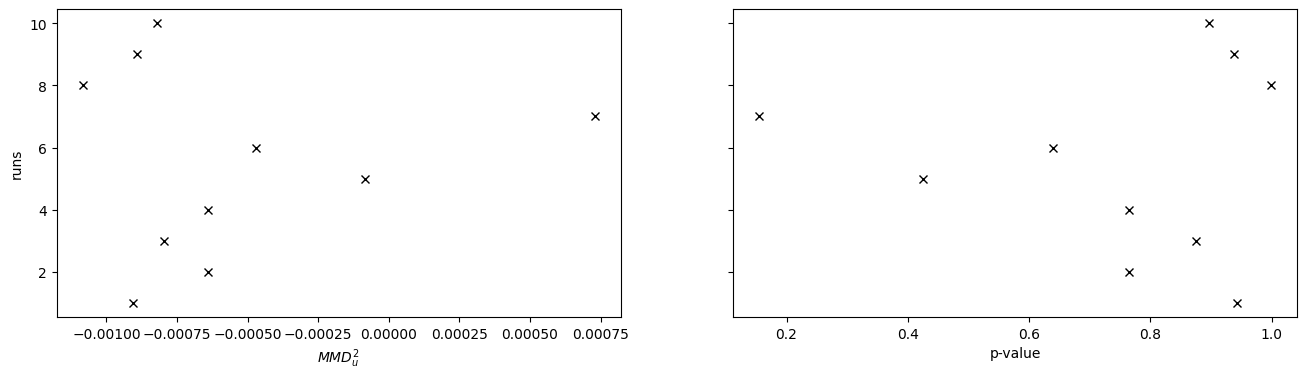

In [17]:
figMmd, axMmd = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
runs = np.arange(1, nbSamples+1)

axMmd[0].plot(MMDs, runs, "xk")
axMmd[1].plot(pVals, runs, "xk")
axMmd[0].set_xlabel(r'$MMD^2_u$')
axMmd[1].set_xlabel("p-value")
_ = axMmd[0].set_ylabel("runs")

Counting the runs with p-values above the 5% threshold.

In [18]:
(np.array(pVals) >= .05).mean()

1.0